Dataset

pre requisits

In [36]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [37]:
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(static_image_mode =True , min_detection_confidence =0.1, model_complexity =2)

mp_drawing =mp.solutions.drawing_utils


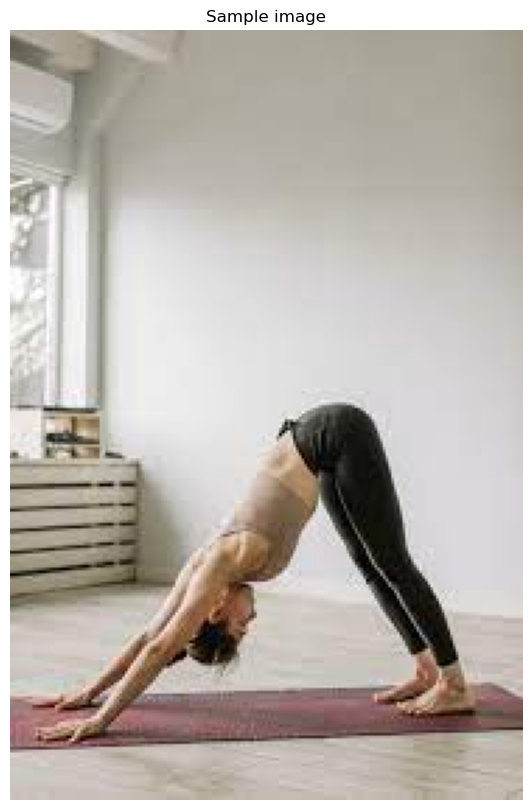

NOSE:
x: 0.47033166885375977
y: 0.7713127732276917
z: -0.10374630987644196
visibility: 0.9488964676856995

LEFT_EYE_INNER:
x: 0.4490792155265808
y: 0.7831100225448608
z: -0.15546776354312897
visibility: 0.9292857646942139



In [38]:
sample_image =cv2.imread("C:/Users/knkmo/OneDrive/Desktop/pose1.jpeg")

plt.figure(figsize=[10,10])

plt.title('Sample image');plt.axis('off');plt.imshow(sample_image[:,:,::-1]);plt.show()

results = pose.process(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
if results.pose_landmarks:
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')
        

In [39]:
image_height, image_width, _ = np.shape(sample_image)

if results.pose_landmarks:
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 86.07069540023804
y: 212.1110126376152
z: -18.985574707388878
visibility: 0.9488964676856995

LEFT_EYE_INNER:
x: 82.18149644136429
y: 215.35525619983673
z: -28.4506007283926
visibility: 0.9292857646942139



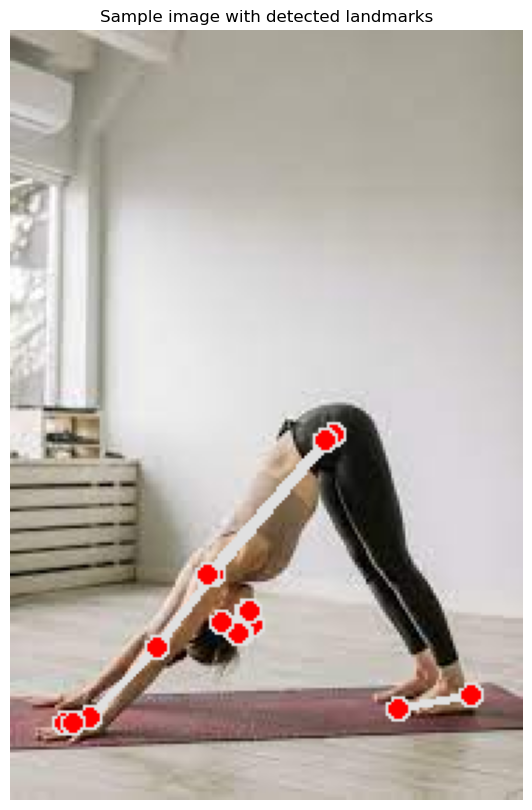

In [40]:
img_copy =sample_image.copy()

if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks,
                              connections=mp_pose.POSE_CONNECTIONS)
    plt.figure(figsize=[10,10])
    plt.title('Sample image with detected landmarks');plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

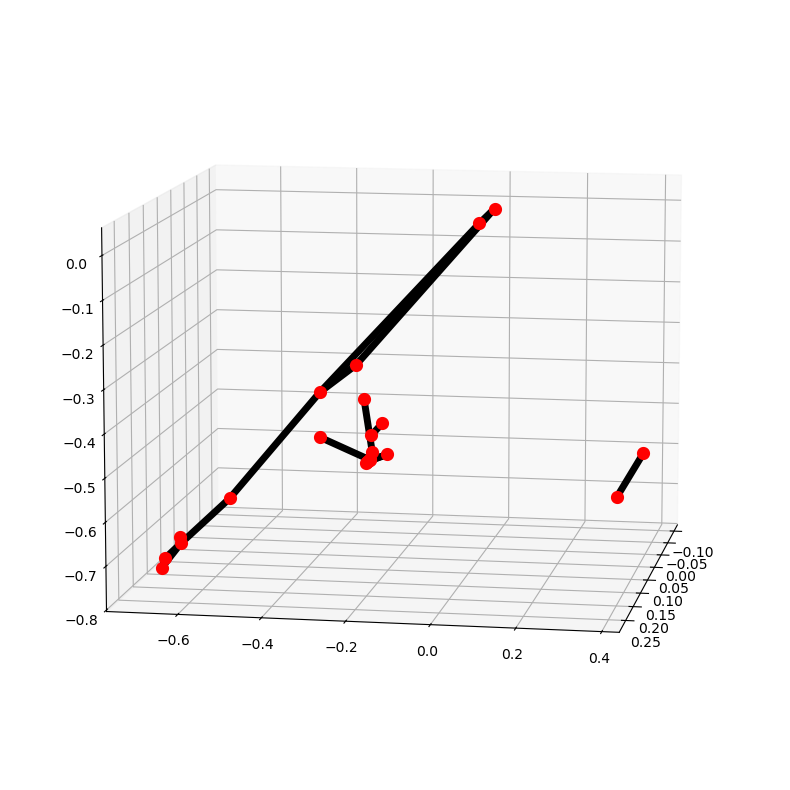

In [41]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [42]:
def detectPose(image, pose, display=True):

    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(imageRGB)

    height, width,_=image.shape

    landmarks=[]
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=output_image,landmark_list= results.pose_landmarks, connections= mp_pose.POSE_CONNECTIONS)
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x*width), int(landmark.y*height), (landmark.z*width)))

    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Input Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    else:
        return output_image, landmarks

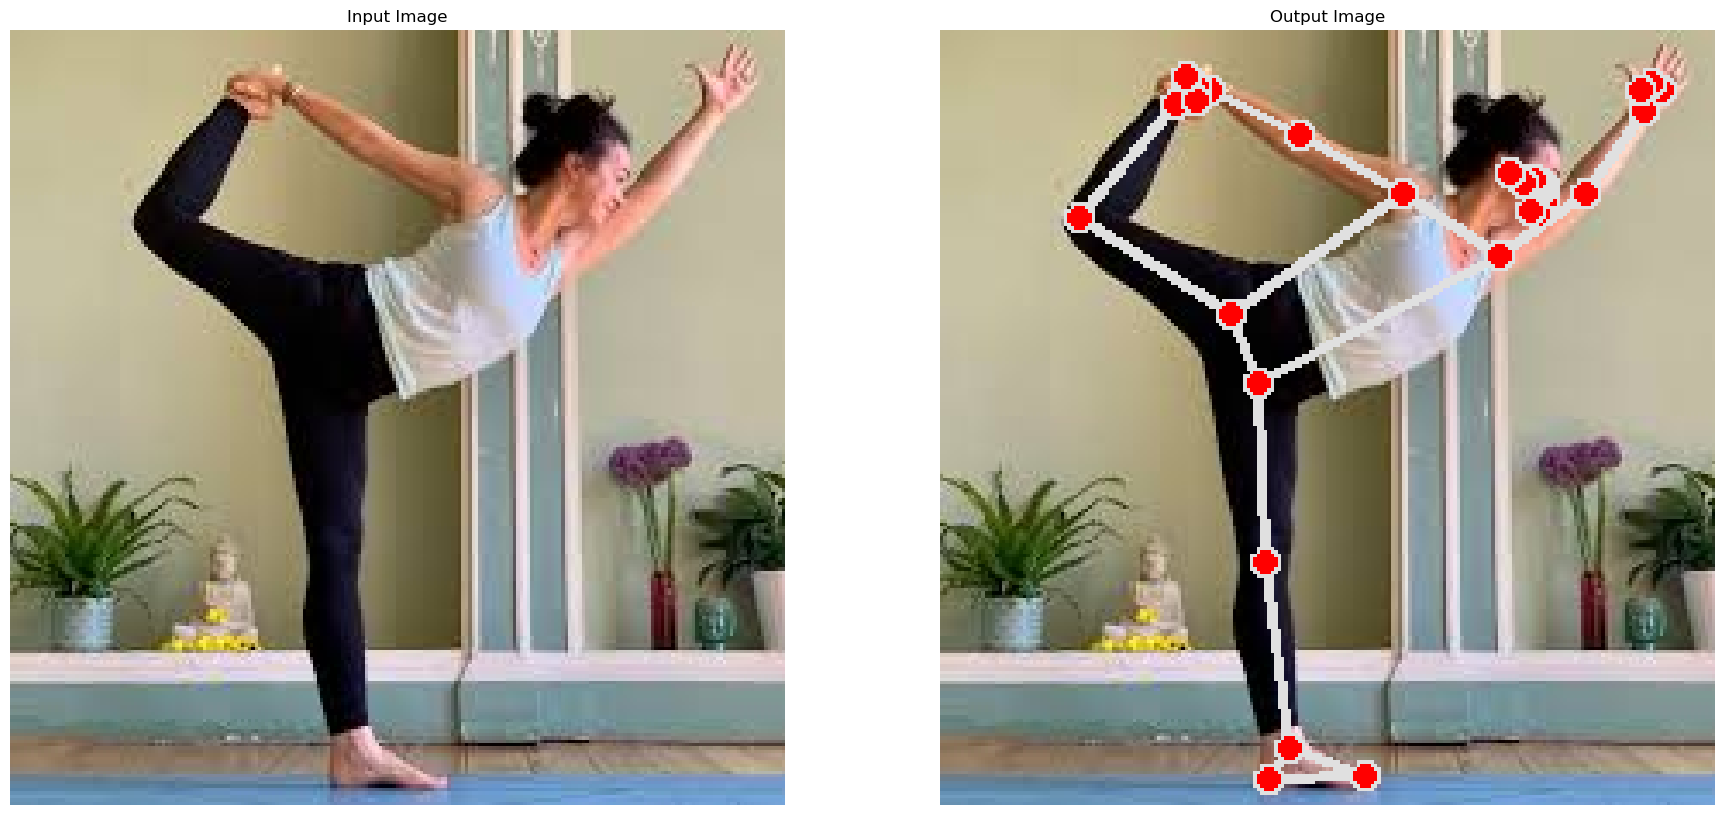

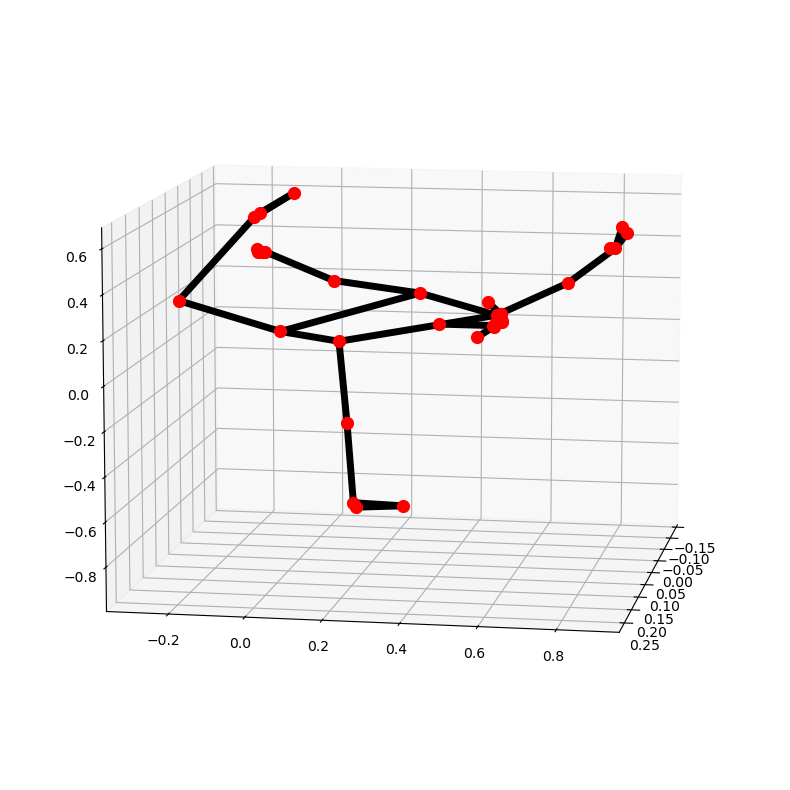

In [43]:
image =cv2.imread("C:/Users/knkmo/OneDrive/Desktop/pose2.jpeg")
detectPose(image, pose, display=True)

In [44]:
pose_video =mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

video=cv2.VideoCapture(0)

cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1=0

while video.isOpened():
    ok, frame = video.read()
    if not ok:
        break
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    frame=cv2.resize(frame, (int(frame_width*(640/frame_height)), 640))
    frame, _ = detectPose(frame, pose_video, display=False)

    time2=time()

    if (time2-time1)>0:
        frames_per_second = 1.0/(time2-time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10,30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    time1=time2
    cv2.imshow('Pose Detection', frame)
    k=cv2.waitKey(1) & 0xFF
    if(k==27):
        break
video.release()
cv2.destroyAllWindows()

In [45]:
def calculateAngle(landmark1, landmark2, landmarks3):
    x1,y1,_=landmark1
    x2,y2,_=landmark2
    x3,y3,_=landmarks3
    angle =math.degrees(math.atan2(y3-y2,x3-x2)-math.atan2(y1-y2, x1-x2))
    if angle<0:
        angle +=360
    return angle
    

In [46]:
angle = calculateAngle((558,326,0),(642,333,0),(718,321,0))
print(f'The Calculate angle is {angle}')

The Calculate angle is 166.26373169437744


In [47]:
def classifyPose(landmarks, output_image, display=False):
    label = 'Unknown Pose'
    color = (0, 0, 255)  # Default color: Red for unknown pose
    
    # Calculate angles for relevant joints
    left_elbow_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
        landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value],
    )
    right_elbow_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value],
    )
    left_shoulder_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
    )
    right_shoulder_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
    )
    left_knee_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
        landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value],
    )
    right_knee_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value],
    )

    # Classify poses based on angles
    if 165 < left_elbow_angle < 195 and 165 < right_elbow_angle < 195:
        if 80 < left_shoulder_angle < 120 and 80 < right_shoulder_angle < 120:
            if (165 < left_knee_angle < 195 or 165 < right_knee_angle < 195):
                if 90 < left_knee_angle < 120 or 90 < right_knee_angle < 120:
                    label = "Warrior II Pose"
                elif 160 < left_knee_angle < 195 or 160 < right_knee_angle < 195:
                    label = "T Pose"
    if 165 < left_knee_angle < 195 or 165 < right_knee_angle < 195:
        if 315 < left_knee_angle < 335 or 25 < right_knee_angle < 45:
            label = "Tree Pose"

    # Update label color to green for a recognized pose
    if label != "Unknown Pose":
        color = (0, 255, 0)

    # Add text to the image
    cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)

    # Display the output image
    if display:
        plt.figure(figsize=[10, 10])
        plt.imshow(output_image[:, :, ::-1])  # Convert BGR to RGB for proper display
        plt.title("Output Image")
        plt.axis('off')
    else:
        return output_image, label


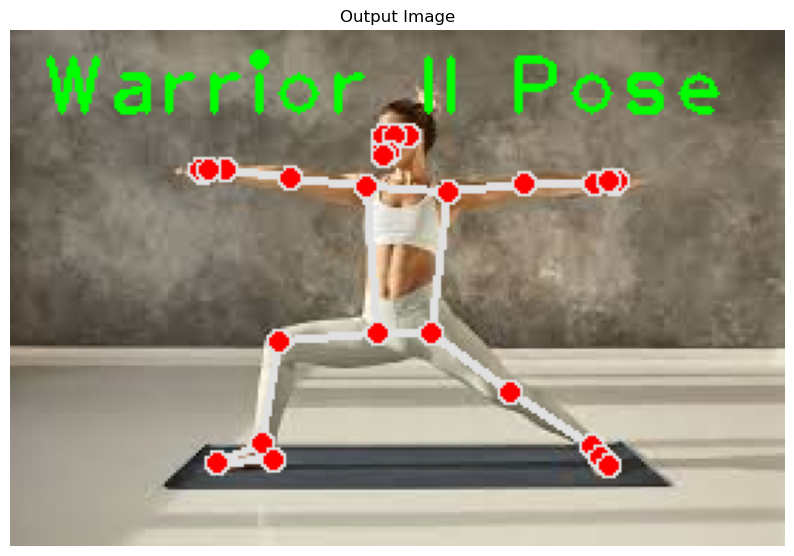

In [48]:
image =cv2.imread("D:/images.jpeg")
output_image,landmarks =detectPose(image,pose,display=False)
if landmarks:
    classifyPose(landmarks,output_image,display =True)


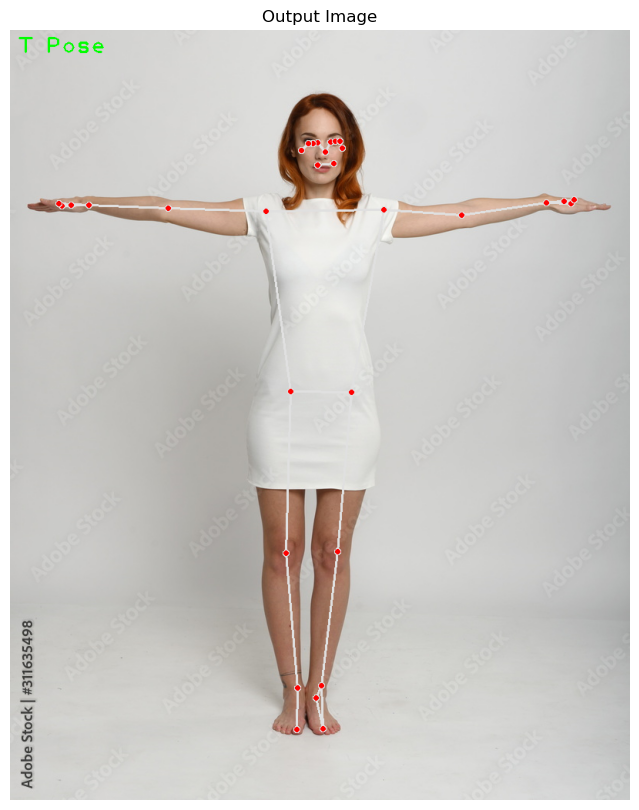

In [49]:
image =cv2.imread("D:/t_pose.jpg")
output_image,landmarks =detectPose(image,pose,display=False)
if landmarks:
    classifyPose(landmarks,output_image,display =True)

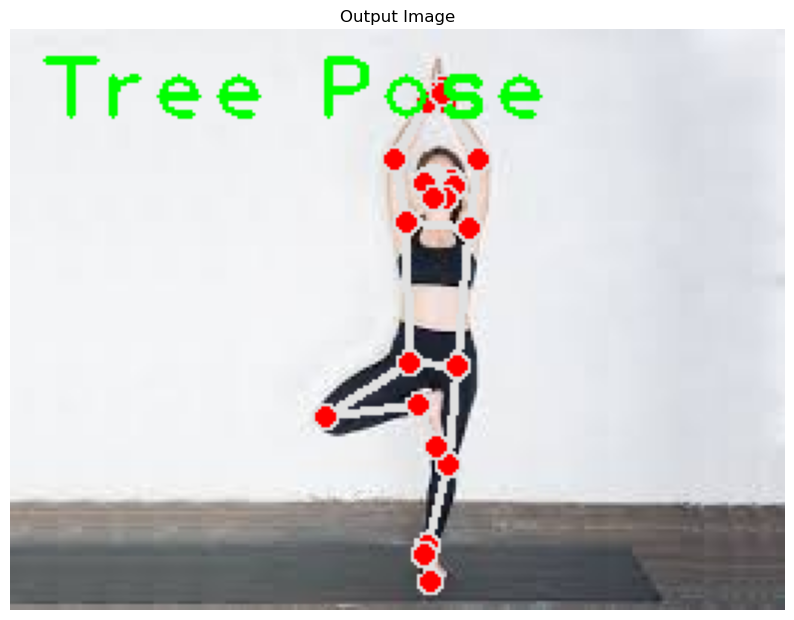

In [50]:
image =cv2.imread("D:/tree_pose.jpeg")
output_image,landmarks =detectPose(image,pose,display=False)
if landmarks:
    classifyPose(landmarks,output_image,display =True)

In [51]:
pose_video =mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5,model_complexity=1)
cap=cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,960)
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)
while cap.isOpened():
    ok,frame =cap.read()
    if not ok:
        continue
    frame =cv2.flip(frame,1)
    frame_height,frame_widht, _= frame.shape
    frame =cv2.resize(frame, (int(frame_width*(640/frame_height)),640))
    frame, landmarks = detectPose(frame,pose_video,display=False)
    if landmarks:
        frame,_ =classifyPose(landmarks,frame,display=False)
    cv2.imshow('Pose Classification', frame)
    k=cv2.waitKey(1) & 0xFF
    if k==27:
        break
cap.release()
cv2.destroyAllWindows()

